In [5]:
# system packages
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os
import boto3
from botocore.client import Config
from botocore import UNSIGNED

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import math
from evaluation_table import EvalTable

# model packages
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import joblib
from shapely.geometry import Point
import geopandas as gpd
import pyproj
from pyproj import datadir
pyproj.datadir.get_data_dir()
datadir.set_data_dir('/home/jovyan/envs/devcon_xgboost/share/proj')  # replace with the actual path to the PROJ data

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

In [6]:
# Load the train and test dataset
data_train = pd.read_pickle(f"{output_path}train_dataset.pkl")
data_test = pd.read_pickle(f"{output_path}test_dataset.pkl")
station_list = data_train.station_id.unique()

#### 5.2. Scaling the Data
Generally, scaling the inputs is not required in decision-tree ensemble models. However, some studies suggest scaling the inputs since XGBoost uses the Gradient Decent algorithm in its core optimization. So here we will try both 
scaled and unscaled inputs to see the difference.
We will scale the data by using the *MinMaxScaler()* function from the Scikit-Learn library. 

In [7]:
# Function for scaling the data. 
def input_scale(x_train, y_train):

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_train_scaled, y_train_scaled = \
    scaler_x.fit_transform(x_train), scaler_y.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)
    joblib.dump(scaler_x, f'{output_path}scaler_x.joblib')
    joblib.dump(scaler_y, f'{output_path}scaler_y.joblib')
    return x_train_scaled, y_train_scaled, scaler_x, scaler_y


#### 5.3. Automatic Hypermeter Tuning
We investigated different values for each parameter, trying to tune it manually, which shows how difficult and time-consuming this process is. So, the next step is to use a simple automatic tuning method, Grird Search, to find the optimal hyperparameter values. To do so, we will use the *GirdSearchCV()* function of the Scikit-Learn library. 
This method gets possible values for each parameter and then tests all possible combinations one by one. It finds the optimal value, but it is very slow. It also uses cross-validation to evaluate each combination. 

First, we divide and scale our whole dataset for the automatic tuning. 

In [8]:
# Initialize dictionaries for storing scaled test datasets.
x_test_scaled = {}
y_test_scaled = {}
x_test = {}  # Missing declaration in your provided code.
y_test = {}  # Missing declaration in your provided code.


# Assigning features by selecting all but the last column from the data_train DataFrame and resetting the index.
x_train = data_train.iloc[:, 2:-1].reset_index(drop=True)
# Assigning the target by selecting the last column from the data_train DataFrame and resetting the index.
y_train = data_train.iloc[:, -1].reset_index(drop=True)

# Scale the training data and retrieve the scalers for later use on the test data.
x_train_scaled, y_train_scaled, scaler_x, scaler_y = input_scale(x_train, y_train)

# Loop over each station name from the list of station IDs.
for station_name in station_list:
    # Extract and store the features for the test data for each station.
    x_test[station_name] = data_test[data_test.station_id == station_name].iloc[:, 2:-1]
    # Extract and store the target variable for the test data for each station.
    y_test[station_name] = data_test[data_test.station_id == station_name].iloc[:, -1]
    # Scale the extracted test features and targets using the previously fitted scalers.
    x_test_scaled[station_name] = scaler_x.transform(x_test[station_name])
    y_test_scaled[station_name] = scaler_y.transform(y_test[station_name].values.reshape(-1, 1)).reshape(-1)


with open(f"{output_path}x_tes.pkl", 'wb') as file:
    pickle.dump(x_test_scaled, file)
with open(f"{output_path}y_test.pkl", 'wb') as file:
    pickle.dump(y_test_scaled, file)

Then, we select the possible values or range of values. 

In [9]:
# Define the range of hyperparameters for XGBoost tuning.
# Note that 'range(100, 300, 200)' implies a single value because the step size leads directly to the limit.
# If you intend multiple steps, adjust the range appropriately.
hyperparameters_xgboost = {
    'max_depth': range(2, 4),  # Generates [2, 3] because 'range' is exclusive of the stop value.
    'n_estimators': range(100, 1000, 200),  
    'eta': [0.1, 0.01, 0.05] 
}

# Paths for saving the tuned hyperparameters and the trained model.
path_model_save_hyperparameters = f"{output_path}best_model_hyperparameters_xgboost.pkl"
path_model_save_model = f"{output_path}best_model_xgboost.pkl"


Next, we create a new XGBoost model and the grid search function. Then, we will run the function and compare the results with those in the previous section. 

In [10]:
# Initialize an XGBoost regressor model.
xgboost_model_automatic = xgb.XGBRegressor()

# Setup GridSearchCV with the XGBoost model and hyperparameter grid.
grid_search_3 = GridSearchCV(estimator=xgboost_model_automatic,  # Corrected to use the initialized model
                             param_grid=hyperparameters_xgboost,  # Dictionary of parameters to try
                             scoring='neg_mean_absolute_error',   # Scoring method MAE, reported as negative for maximization
                             cv=3,                                # Number of cross-validation folds
                             n_jobs=-1,                           # Use all available CPU cores
                             verbose=3)                           # Show detailed progress (level 3)

# Fit the GridSearchCV to the scaled training data.
grid_search_3.fit(x_train_scaled, y_train_scaled)

# Retrieve the best estimator from the grid search.
optimized_xgboost_model = grid_search_3.best_estimator_

# Output the best parameters and the corresponding score for those parameters.
print(f"Best parameters found: {grid_search_3.best_params_}")
print(f"Best RMSE: {abs(grid_search_3.best_score_)}")  # Print the absolute value of the RMSE



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-0.027 total time=   0.1s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-0.037 total time=   0.1s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-0.024 total time=   0.1s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-0.033 total time=   0.2s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-0.024 total time=   0.2s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-0.026 total time=   0.3s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=500;, score=-0.034 total time=   0.4s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=500;, score=-0.023 total time=   0.4s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=500;, score=-0.026 total time=   0.4s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=700;, score=-0.033 total time=   0.5s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=700;, score=-0.023 total time= 

**Remember to save the best parameters after finding them!!!!!!**

In [11]:
joblib.dump(grid_search_3, path_model_save_hyperparameters)

['/home/jovyan/mydrive/new_devcon/hydromachine-tutorials/decision_trees/03.output/best_model_hyperparameters_xgboost.pkl']

<div style="display: flex; justify-content: center; align-items: center; margin: auto;">
    <div style="margin: 10px;">
        <img src="../04.pic/q2.png" alt="Image 1" width="300">
    </div>
    <div style="margin: 10px;">
        <img src="q1.png" alt="Image 2" width="300">
    </div>
    <div style="margin: 10px;">
        <img src="q3.jpg" alt="Image 3" width="300">
    </div>
</div>


<center>
<strong style="font-size: 24px;">What other methods can we use to tune the parameters????</strong>
</center>



If the training dataset is too big (which is the case in real-world examples), we only use a small part to tune the parameters. Then, we have to train the model on the full dataset and save the model using the code below:

In [12]:
# Fit the optimized XGBoost model to the scaled training data.
optimized_xgboost_model = optimized_xgboost_model.fit(x_train_scaled, y_train_scaled)

# Save the trained model to a file using pickle. This serialized file can be loaded later to make predictions.
pickle.dump(optimized_xgboost_model, open(path_model_save_model, "wb"))


#### 5.4. Feature Selection
Feature selection is an important part of preprocessing the data, which we skipped since we first had to learn the model structure. After training the model, decision-tree ensembles can show us the importance of each feature in the prediction process. Then, based on the importance, we can remove less important features to make the model more complex.

First we will try it for one station and the model that we trained with one station data. 

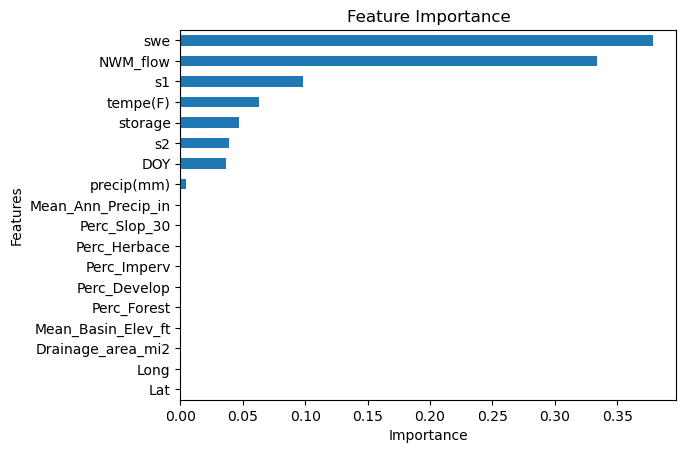

In [13]:
with open(f'{output_path}best_manuall_model.pkl', 'rb') as file:
    xgboost_model = pickle.load(file)
    
# Extract the feature names from the training dataset.
cols = x_train.columns
# Create a DataFrame containing the feature importances extracted from the optimized XGBoost model.
# Transpose the DataFrame for easier plotting (columns become rows and vice versa).
FI = pd.DataFrame(xgboost_model.feature_importances_, index=cols, columns=['Importance'])

# Plotting the feature importances as a horizontal bar chart.
ax = FI.sort_values('Importance', ascending=True).plot.barh()  # Sorting helps in better visualization.
ax.get_legend().remove()  # Remove the legend since it's typically not needed for a single-variable plot.
plt.title('Feature Importance')  # Setting the title of the plot.
plt.xlabel('Importance')  # Adding an x-label for clarity.
plt.ylabel('Features')  # Adding a y-label for clarity.
plt.show()  # Ensure the plot is displayed.


Now we will try it for all the stations.

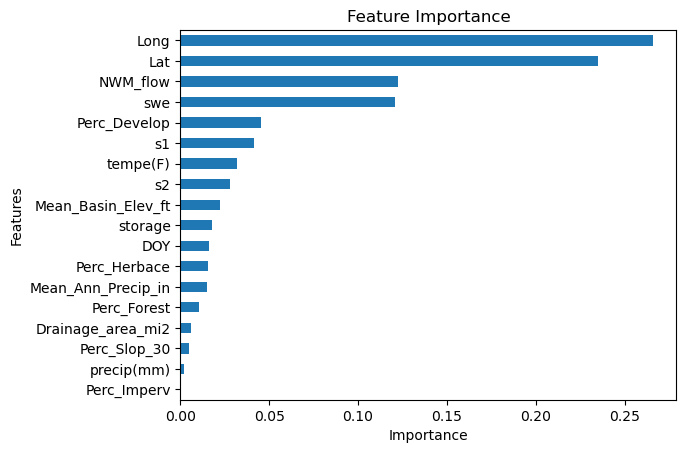

In [14]:
# Extract the feature names from the training dataset.
cols = x_train.columns

# Create a DataFrame containing the feature importances extracted from the optimized XGBoost model.
# Transpose the DataFrame for easier plotting (columns become rows and vice versa).
FI = pd.DataFrame(optimized_xgboost_model.feature_importances_, index=cols, columns=['Importance'])

# Plotting the feature importances as a horizontal bar chart.
ax = FI.sort_values('Importance', ascending=True).plot.barh()  # Sorting helps in better visualization.
ax.get_legend().remove()  # Remove the legend since it's typically not needed for a single-variable plot.
plt.title('Feature Importance')  # Setting the title of the plot.
plt.xlabel('Importance')  # Adding an x-label for clarity.
plt.ylabel('Features')  # Adding a y-label for clarity.
plt.show()  # Ensure the plot is displayed.


[**LETS GO TO THE NEXT PART**](./03.tutorial_post_processing_xgboost_evaluation.ipynb)